In [137]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.layers import LSTM


from itertools import cycle

import matplotlib.pyplot as plt
# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [138]:
data = pd.read_csv('/Users/patricia/Downloads/seasonal_gdp.csv')
data.describe(include = 'all')

,Date,GDP
count,118,118.000000
unique,118,NaN
top,2015年第一季度,NaN
freq,1,NaN
mean,NaN,92146.383051
std,NaN,82182.611122
min,NaN,5262.800000
25%,NaN,23128.475000
50%,NaN,56612.000000
75%,NaN,152120.025000


In [139]:
from functools import reduce 
def str2float(s):
    def dict(s):
        dict1 ={'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,'.':'.'}
        return dict1[s]  
    def fn(x,y):
        return x*10+y
    a =0
    for i in s :
        a +=1
        if i =='.':
            s = s[:a-1]+s[a:]
            break
    if a ==len(s):
        return reduce(fn,map(dict,s))
    else:
        return reduce(fn,map(dict,s))/(10**(len(s)-a+1))

def format_float(x):
    try:
        return float(x)
    except ValueError:
        x=x.replace(",","")
        return str2float(x)

for col in data.columns:
    if col !="Date":
        data[col]=data[col].apply(lambda x: format_float(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    118 non-null    object 
 1   GDP     118 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB


In [140]:
df=data[["Date","GDP"]]
df=df.sort_values("Date")
df.head()

,Date,GDP
117,1992年第一季度,5262.8
115,1992年第三季度,7192.6
116,1992年第二季度,6484.3
114,1992年第四季度,8254.8
113,1993年第一季度,6834.6


In [141]:
fig = px.line(df, x=df.Date, y=df.GDP)
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='GDP chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [142]:
#df=np.array(df)
def dateformat(date):
    if date[6]=='一':
        return date[:4]+'-01'
    elif date[6]=='二':
        return date[:4]+'-02'
    elif date[6]=='三':
        return date[:4]+'-03'
    elif date[6]=='四':
        return date[:4]+'-04'
    else:
        pass
    
df["Date"]=df["Date"].apply(lambda x:dateformat(x))
df.head()

,Date,GDP
117,1992-01,5262.8
115,1992-03,7192.6
116,1992-02,6484.3
114,1992-04,8254.8
113,1993-01,6834.6


In [143]:
import math
df['GDP'] = df['GDP'].apply(lambda x: math.log(x))

fig = px.line(df, x=df.Date, y=df.GDP)
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='GDP chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [161]:
closedf = df.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(118, 1)


In [162]:
training_size=int(len(closedf)*0.65)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (76, 1)
test_data:  (42, 1)


In [163]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (65, 10)
y_train:  (65,)
X_test:  (31, 10)
y_test (31,)


In [164]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (65, 10, 1)
X_test:  (31, 10, 1)


In [165]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=True,activation='relu',dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

#model.add(LSTM(128,return_sequences=True,activation='relu',dropout=0.2, recurrent_dropout=0.2))
#model.add(Dropout(0.2))

model.add(LSTM(64,activation='relu',dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [166]:
m=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=256,batch_size=32,verbose=2, shuffle=False)

Epoch 1/256
3/3 - 7s - loss: 0.2227 - val_loss: 0.6697
Epoch 2/256
3/3 - 0s - loss: 0.1737 - val_loss: 0.5078
Epoch 3/256
3/3 - 0s - loss: 0.1154 - val_loss: 0.2644
Epoch 4/256
3/3 - 0s - loss: 0.0359 - val_loss: 0.0110
Epoch 5/256
3/3 - 0s - loss: 0.0159 - val_loss: 0.0222
Epoch 6/256
3/3 - 0s - loss: 0.0287 - val_loss: 0.0056
Epoch 7/256
3/3 - 0s - loss: 0.0093 - val_loss: 0.0278
Epoch 8/256
3/3 - 0s - loss: 0.0089 - val_loss: 0.0306
Epoch 9/256
3/3 - 0s - loss: 0.0064 - val_loss: 0.0250
Epoch 10/256
3/3 - 0s - loss: 0.0045 - val_loss: 0.0170
Epoch 11/256
3/3 - 0s - loss: 0.0072 - val_loss: 0.0072
Epoch 12/256
3/3 - 0s - loss: 0.0091 - val_loss: 7.1077e-04
Epoch 13/256
3/3 - 0s - loss: 0.0103 - val_loss: 7.5276e-04
Epoch 14/256
3/3 - 0s - loss: 0.0115 - val_loss: 0.0087
Epoch 15/256
3/3 - 0s - loss: 0.0081 - val_loss: 0.0130
Epoch 16/256
3/3 - 0s - loss: 0.0064 - val_loss: 0.0089
Epoch 17/256
3/3 - 0s - loss: 0.0065 - val_loss: 0.0014
Epoch 18/256
3/3 - 0s - loss: 0.0122 - val_loss: 

Epoch 145/256
3/3 - 0s - loss: 0.0050 - val_loss: 0.0101
Epoch 146/256
3/3 - 0s - loss: 0.0045 - val_loss: 0.0055
Epoch 147/256
3/3 - 0s - loss: 0.0032 - val_loss: 6.8077e-04
Epoch 148/256
3/3 - 0s - loss: 0.0027 - val_loss: 6.2542e-04
Epoch 149/256
3/3 - 0s - loss: 0.0043 - val_loss: 6.5032e-04
Epoch 150/256
3/3 - 0s - loss: 0.0033 - val_loss: 8.0084e-04
Epoch 151/256
3/3 - 0s - loss: 0.0038 - val_loss: 0.0013
Epoch 152/256
3/3 - 0s - loss: 0.0040 - val_loss: 8.4371e-04
Epoch 153/256
3/3 - 0s - loss: 0.0035 - val_loss: 6.4413e-04
Epoch 154/256
3/3 - 0s - loss: 0.0032 - val_loss: 5.2681e-04
Epoch 155/256
3/3 - 0s - loss: 0.0029 - val_loss: 4.2816e-04
Epoch 156/256
3/3 - 0s - loss: 0.0044 - val_loss: 4.4791e-04
Epoch 157/256
3/3 - 0s - loss: 0.0037 - val_loss: 0.0033
Epoch 158/256
3/3 - 0s - loss: 0.0037 - val_loss: 0.0137
Epoch 159/256
3/3 - 0s - loss: 0.0058 - val_loss: 0.0082
Epoch 160/256
3/3 - 0s - loss: 0.0056 - val_loss: 8.5103e-04
Epoch 161/256
3/3 - 0s - loss: 0.0042 - val_loss

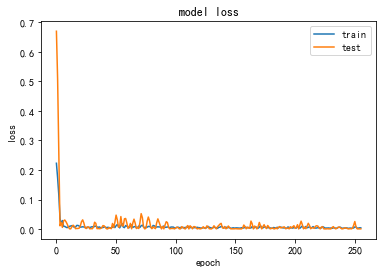

In [167]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [168]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

((65, 1), (31, 1))

In [169]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [170]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.17941919924351168
Train data MSE:  0.032191249057182944
Test data MAE:  0.1537729414105316
-------------------------------------------------------------------------------------
Test data RMSE:  0.09945050548516236
Test data MSE:  0.009890403041254308
Test data MAE:  0.08359481074855045


In [171]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9668439777317098
Test data explained variance regression score: 0.8268082152575884


In [172]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9100825355527876
Test data R2 score: 0.7496020867730602


In [173]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original GDP','Train predicted GDP','Test predicted GDP'])


plotdf = pd.DataFrame({'date': df['Date'],
                       'original': df['GDP'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'GDP','date': 'Date'})
fig.update_layout(title_text='Comparision between original vs predicted GDP',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (118, 1)
Test predicted data:  (118, 1)


In [174]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_season = 20
while(i<pred_season):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} season output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next series of seasons: ", len(lst_output))

Output of predicted next series of seasons:  20


In [175]:
last_seasons=np.arange(1,time_step*4+1)
season_pred=np.arange(time_step*4+1,time_step*4+pred_season+1)
print(last_seasons)
print(season_pred)

temp_mat = np.array((len(last_seasons)+season_pred+1,1),dtype=object)
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_seasons_value = temp_mat
next_predicted_seasons_value = temp_mat

last_original_seasons_value[0:time_step*4+1] = scaler.inverse_transform(closedf[len(closedf)-(time_step*4+1):]).reshape(1,-1).tolist()[0]
next_predicted_seasons_value[time_step*4+1:] = scaler.inverse_transform(np.array(lst_output,dtype=object).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_seasons_value':last_original_seasons_value,
    'next_predicted_seasons_value':next_predicted_seasons_value
})

#names = cycle(['Last 20 seasons GDP','Predicted next 20 seasons GDP'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_seasons_value'],
                                                      new_pred_plot['next_predicted_seasons_value']],
              labels={'value': 'Seasonal GDP','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 5 years vs next 5 years GDP',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Seasons')

#fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [176]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['GDP'])

fig = px.line(lstmdf,labels={'value': 'GDP','index': 'Timestamp'})
fig.update_layout(title_text='Plotting entire GDP with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Seasonal GDP')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

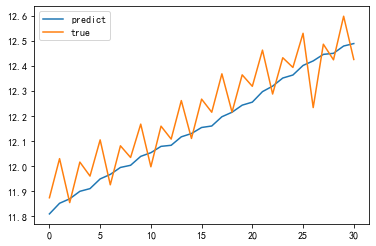

In [177]:
from matplotlib import pyplot
pyplot.plot(test_predict, label='predict')
pyplot.plot(original_ytest, label='true')
pyplot.legend()
pyplot.show()

https://www.kaggle.com/anseldsouza/bitcoin-price-prediction-with-lstm